# Hiring prediction on un-balanced data
    
The topic is hiring prediction, from data representating job's applications. The dataset describes the job's applications with 10 features:  

  * date: date of application, 
  * hair: color of hair, 
  * age, 
  * experience: number of years of experience, 
  * salary: salary expectation, 
  * gender, 
  * diploma, 
  * speciality, 
  * note: technical test note, 
  * availability,
  
and "hiring" is the target variable: 'yes' or 'no'. Thus, the problem is turned into a binary classification task.   
    
    
### Outline:
* Exploratory Data Analysis
* Statistical analysis
* Model Selection
* Conclusion

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import time
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.decomposition import PCA
from statistics import mean
# my modules
import mydata_processing
import mydata_stats
import mymodeling
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

/home/christelle/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# 1) Exploratory Data Analysis

The dataset contains 13 columns: 7 numerical variables and 6 categorical variables.<br>
The Unnamed:0 and index columns will be removed as useless indices.

In [2]:
data = pd.read_csv('data.csv', sep=',')
print('---------------------------------------')
print('        Dataset size:', data.shape)
print('---------------------------------------')
print('\nData types: \n')
print(data.dtypes)

---------------------------------------
        Dataset size: (20000, 13)
---------------------------------------

Data types: 

Unnamed: 0        int64
index             int64
date             object
hair             object
age             float64
exp             float64
salairy         float64
gender           object
diploma          object
speciality       object
note            float64
availability     object
hiring            int64
dtype: object


In [3]:
data.head()

,Unnamed: 0,index,date,hair,age,exp,salairy,gender,diploma,speciality,note,availability,hiring
0,0,0,2012-06-02,red,25.0,9.0,26803.0,F,licence,geology,97.08,no,0
1,1,1,2011-04-21,blond,35.0,13.0,38166.0,M,licence,drilling,63.86,no,0
2,2,2,2012-09-07,blond,29.0,13.0,35207.0,M,licence,geology,78.50,no,0
3,3,3,2011-07-01,brown,NaN,12.0,32442.0,M,licence,geology,45.09,no,0
4,4,4,2012-08-07,red,35.0,6.0,28533.0,F,licence,detective,81.91,no,0


In [4]:
data = data.drop(columns=['Unnamed: 0','index'])
print('New dataset size:', data.shape)
dataset = data.copy()

New dataset size: (20000, 11)


## 1.1) Categorical variables

There are 6 categorical variables: date, hair, gender, diploma, speciality and availability.
The embauche variable is turned into a new categorical feature in order to perform a chi2 test.
The chi2 test below allows to determine which variables are important for prediction.

We obtain that date, hair and availability are not relevant for prediction.

In [5]:
categorical_var = list(data.dtypes.loc[data.dtypes == 'object'].index)
print("Categorical variables: \n", categorical_var)
print('---------------------------------------------------------------\n')
for var in categorical_var:
    print(var)
    print(data[var].unique())

Categorical variables: 
 ['date', 'hair', 'gender', 'diploma', 'speciality', 'availability']
---------------------------------------------------------------

date
['2012-06-02' '2011-04-21' '2012-09-07' ... '2011-03-04' '2014-08-26'
 '2011-07-11']
hair
['red' 'blond' 'brown' 'chestnut' nan]
gender
['F' 'M' nan]
diploma
['licence' 'master' 'phd' 'bachelor' nan]
speciality
['geology' 'drilling' 'detective' 'archeology' nan]
availability
['no' 'yes' nan]


In [6]:
# convert 'hiring' into a new categorical feature 'hiring_bis'
data_test = dataset.copy()
data_test["hiring_bis"] = np.where(data_test['hiring']==1, 'yes', 'no') 
data_test = data_test.dropna()     

for var in categorical_var:
    mydata_stats.chi2_test(data_test,var,"hiring_bis", 0.05) 

date is NOT important for hiring_bis prediction.
hair is NOT important for hiring_bis prediction.
gender is important for hiring_bis prediction.
diploma is important for hiring_bis prediction.
speciality is important for hiring_bis prediction.
availability is NOT important for hiring_bis prediction.


## 1.2) Numerical variables

We represent the numerical variables and we observe some outliers and worthless values. <br>
In order to clean data, we proceed as follows:
* age > 14
* exp >= 0
* note <= 100
* remove NaN

In [7]:
numerical_list = ['age','exp','salairy','note','hiring']  
data[numerical_list].describe(include="all") 

,age,exp,salairy,note,hiring
count,19909.000000,19904.000000,19905.000000,19886.000000,20000.000000
mean,35.004521,9.500352,34974.343934,75.168762,0.114600
std,9.609169,3.012109,5003.099616,17.095926,0.318547
min,-3.000000,-2.000000,14128.000000,8.680000,0.000000
25%,29.000000,7.000000,31596.000000,63.720000,0.000000
50%,35.000000,9.000000,34979.000000,75.080000,0.000000
75%,41.000000,12.000000,38358.000000,86.617500,0.000000
max,74.000000,23.000000,53977.000000,143.220000,1.000000


In [8]:
# cleaning data
data_clean = data.copy()
data_clean = mydata_processing.data_cleaning(data_clean)
data_clean = data_clean.dropna()
data_clean.head()

,age,exp,salairy,gender,diploma,speciality,note,availability,hiring
0,25.0,9.0,26803.0,F,licence,geology,97.08,no,0
1,35.0,13.0,38166.0,M,licence,drilling,63.86,no,0
2,29.0,13.0,35207.0,M,licence,geology,78.50,no,0
4,35.0,6.0,28533.0,F,licence,detective,81.91,no,0
5,37.0,8.0,38558.0,M,master,geology,63.46,no,1


### 1.2.1) Correlations coefficients

We represent the correlation coefficients and it shows that the variables are not linearly correlated.
As a first insight conclusion, the whole feature might be kept in ordre to make prediction since each variable contribute to additional information.

In [9]:
data_clean.corr()

,age,exp,salairy,note,hiring
age,1.000000,-0.003840,0.001303,-0.003982,-0.015498
exp,-0.003840,1.000000,0.007705,-0.015437,0.003906
salairy,0.001303,0.007705,1.000000,-0.402557,-0.028583
note,-0.003982,-0.015437,-0.402557,1.000000,0.017561
hiring,-0.015498,0.003906,-0.028583,0.017561,1.000000


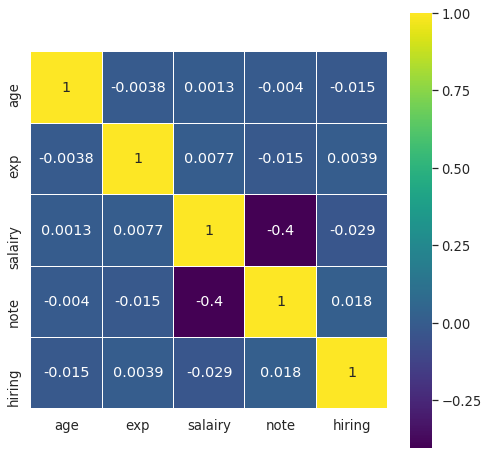

In [10]:
colormap = plt.cm.viridis
plt.figure(figsize=(8,8))
sns.set(font_scale=1.2)
sns.heatmap(data_clean.corr(), linewidths=0.05, square=True, cmap=colormap, annot=True)

### 1.2.2) Variables distribution

We plot the distribution of the variables and we observe that all the numercial variables are normally distributed and no outlier stands out remarkably.

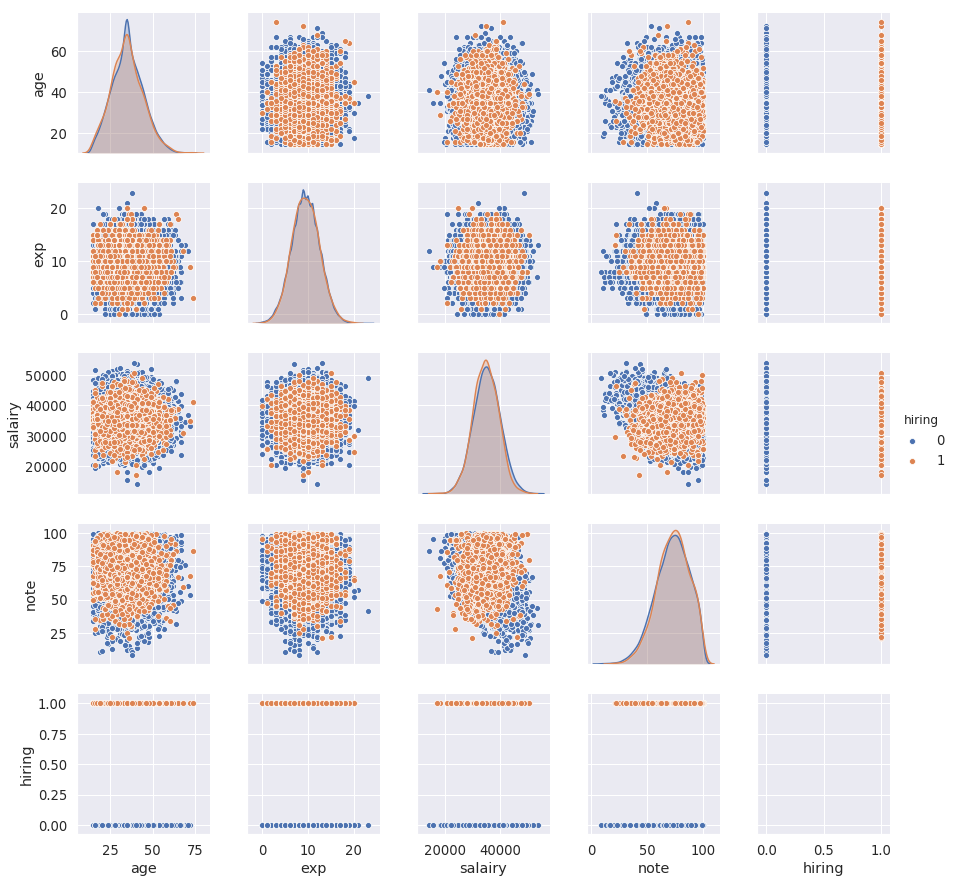

In [11]:
sns.pairplot(data_clean, hue="hiring")

In [12]:
ordinal_list = ['age','exp','salairy','note']   
ordinal_var = data_test[ordinal_list]    
mydata_stats.anova_hiring(ordinal_var, data_test)

age
F_onewayResult(statistic=3.4735900244455262, pvalue=0.06237123962275814)
exp
F_onewayResult(statistic=1.0371089612349855, pvalue=0.3085077596717369)
salairy
F_onewayResult(statistic=0.12433186217634838, pvalue=0.7243868201224445)
note
F_onewayResult(statistic=0.2211165899359864, pvalue=0.6381958386820781)


## 1.3) Conclusion

* For the categorical variables, the study shows that date, hair and availability are not important for prediction.<br>
  We decide to remove date and hair but to keep dispo.
  
* For the numerical variables, all features are important to keep for prediction.

# 2) Statistical analysis

## 2.1) Speciality vs gender

We firt graphically represent the speciality rates and the proportion of gender whithin each speciality.<br>
It reveal that the speciality depends on gender.

Than we perform a chi2 test in order to confirm the visual assumption.

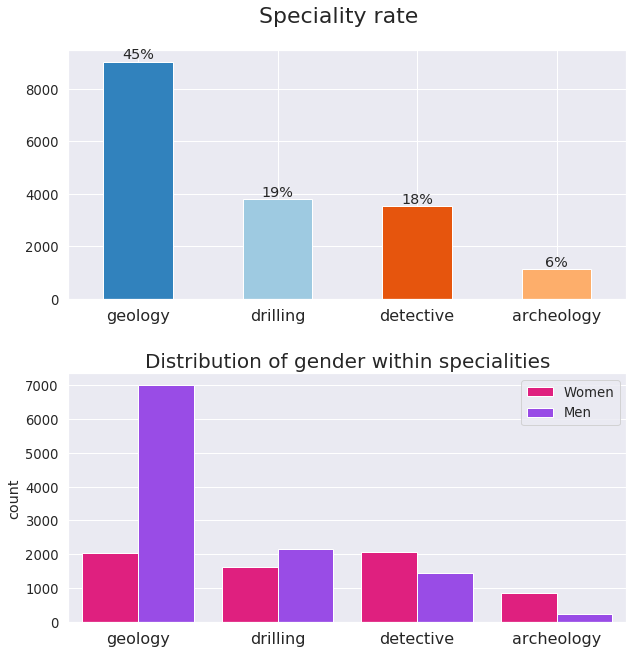

In [13]:
cmap = plt.get_cmap("tab20c")
colors_bar = cmap(np.arange(9)*2)
colors=["#ff007f","#9933ff"]
fig, ax = plt.subplots(2,1, figsize=(10,10))
data_clean['speciality'].value_counts().head(100).plot.bar(ax=ax[0], color=colors_bar)
sns.countplot(x="speciality", hue="gender", data=data_clean, ax=ax[1], palette=colors)

g = data['speciality'].value_counts()[0]
f = data['speciality'].value_counts()[1]
d = data['speciality'].value_counts()[2]
a = data['speciality'].value_counts()[3]
tot = g+f+d+a
for p in ax[0].patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax[0].annotate('{:.0f}%'.format(100.*y/tot), (x.mean(),y),ha='center', va='bottom')      

fig.suptitle("Speciality rate", fontsize=22)
ax[0].set_xticklabels(('geology', 'drilling', 'detective', 'archeology'),fontsize = 16, rotation=360)
ax[1].set_xticklabels(('geology', 'drilling', 'detective', 'archeology'),fontsize = 16, rotation=360)
plt.xlabel('')
ax[1].set_title('Distribution of gender within specialities',fontsize=20)
ax[1].legend(['Women','Men'],title='')
plt.subplots_adjust(hspace = 0.3, top=0.92) 

### Chi2 test:

In [14]:
mydata_stats.chi2_test(data_clean,"gender","speciality", 0.05)

gender is important for speciality prediction.


## 2.2) Cheveux vs salaire

We represent the box of cheveux with respect to salaire and observe that all the features are overall equally distributed. <br>
We perform an ANOVA test in order to determime the statistical dependance between cheveux and salaire.

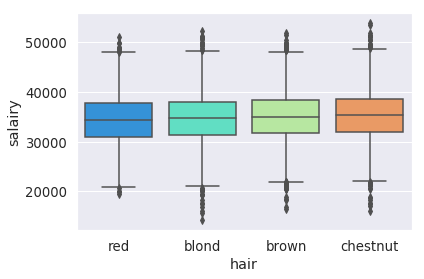

In [15]:
sns.boxplot(x='hair',y='salairy',data=data,palette='rainbow')

In [16]:
# ANOVA test
mydata_stats.anova_hair(data[['salairy']], data)

salairy
F_onewayResult(statistic=nan, pvalue=nan)


## 2.3) Experience vs note

We observed in 1.2.1) that exp and note are not linearly correlated.<br>
Indeed, there is a slightly anti-correlating of 0.015, which is not significative.

The plot below confirms this trend.

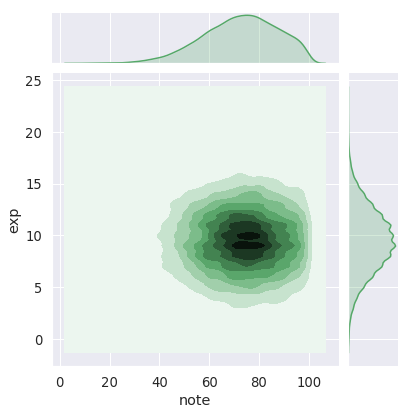

In [17]:
sns.jointplot(x='note', y='exp', data=data_clean, kind="kde", color="g")

# 3) Model selection

We begin by a pre-processing of the dataset: cleaning, encoding, splitting and scaling.
We present some models performance in order to select our model.
Then the selected model Random Forest is ran for a baseline.
Finally we present some improvement of the selected model.


## 3.1) Data pre-processing

The dataset is cleaned as explained in Section 1), so the NaN values are removed, the variables hair and date are removed.
Then the categorical variables are encoding. For variables with more than two values, we perform a dummies encoding in order to avoid a weight ponderation by algorithms.
Then we split the data into train and test splitting and finally we perform a scaling of data.

In [18]:
# cleaning data
data_clean = dataset.copy()
data_clean = mydata_processing.data_cleaning(data_clean)
data_clean = data_clean.dropna()
data = data_clean.copy()
print('dataset size:', data.shape)
data.head()

dataset size: (17478, 9)


,age,exp,salairy,gender,diploma,speciality,note,availability,hiring
0,25.0,9.0,26803.0,F,licence,geology,97.08,no,0
1,35.0,13.0,38166.0,M,licence,drilling,63.86,no,0
2,29.0,13.0,35207.0,M,licence,geology,78.50,no,0
4,35.0,6.0,28533.0,F,licence,detective,81.91,no,0
5,37.0,8.0,38558.0,M,master,geology,63.46,no,1


In [19]:
# encoding data
data = mydata_processing.data_encoding(data)
# train/test splitting
X_train, X_test, y_train, y_test = mydata_processing.data_splitting(data)
# standard scaling
X_train_std, X_test_std = mydata_processing.data_scaling(X_train, X_test) 

## 3.2) Models performance overview

We consider some classifiers: Logistic Regresion, K-Nearest Neighbors, Decision Tree, Random Forest and Support Vector Machine.
The performance's models are evaluated with the average_precision and the accuracy metrics. 
We compare the result of a cross-validation on 5 folds in order to evaluate the over-fitting.<br>
We choose to adopt the Random Forest algorithm which is a good trade off between performance and computational price.

In [20]:
models = []
models.append(('Logistic Regression    ', LogisticRegression()))
models.append(('K-Nearest Neighbors    ', KNeighborsClassifier())) 
models.append(('Decision Tree          ', DecisionTreeClassifier()))
models.append(('Random Forest          ', RandomForestClassifier()))
models.append(('Support Vector Machine ', SVC()))

print("*****************************************")
print("        Cross-validation results")
print("*****************************************\n")

scores = ['average_precision', 'accuracy'] 
for score in scores:
    print(score)
    for name, model in models:
        start = time.time()
        cv_results = cross_validate(model, X_train_std, y_train, cv=5, return_train_score=True, scoring = score)
        stop = time.time()
        print("%s = %0.5f (train) / %0.5f (test) (CPU: %0.3f)" % 
              (name, cv_results['train_score'].mean(), cv_results['test_score'].mean(), stop-start))
    print("")

*****************************************
        Cross-validation results
*****************************************

average_precision
Logistic Regression     = 0.17567 (train) / 0.16919 (test) (CPU: 0.209)
K-Nearest Neighbors     = 0.63244 (train) / 0.39775 (test) (CPU: 5.824)
Decision Tree           = 1.00000 (train) / 0.21937 (test) (CPU: 0.274)
Random Forest           = 0.99678 (train) / 0.40899 (test) (CPU: 0.675)
Support Vector Machine  = 0.57993 (train) / 0.50628 (test) (CPU: 16.740)

accuracy
Logistic Regression     = 0.88336 (train) / 0.88336 (test) (CPU: 0.101)
K-Nearest Neighbors     = 0.91894 (train) / 0.89578 (test) (CPU: 5.647)
Decision Tree           = 1.00000 (train) / 0.85009 (test) (CPU: 0.280)
Random Forest           = 0.98623 (train) / 0.89693 (test) (CPU: 0.687)
Support Vector Machine  = 0.90500 (train) / 0.90150 (test) (CPU: 16.415)



## 3.3) Random Forest

We present the Random Forest results with default parameters and the features importances.

### 3.3.1) Default results

The Random Forest algorithm provides the following results.
We present the classification report, the accuracy and the confustion matrix.
It show that the classifier is good at predicting the negative classe, but bad on classe 1.
Thus, we will make a particular attention on classe 1 (recall and precision).
We plot the ROC and the precision-recall curves which also reveal a poor performance on classe 1.

Classification report:
              precision    recall  f1-score   support

          0       0.91      0.98      0.95      4632
          1       0.67      0.29      0.40       612

avg / total       0.88      0.90      0.88      5244

Accuracy 90.06%
---- Confusion matrix ----
[[4546   86]
 [ 435  177]]


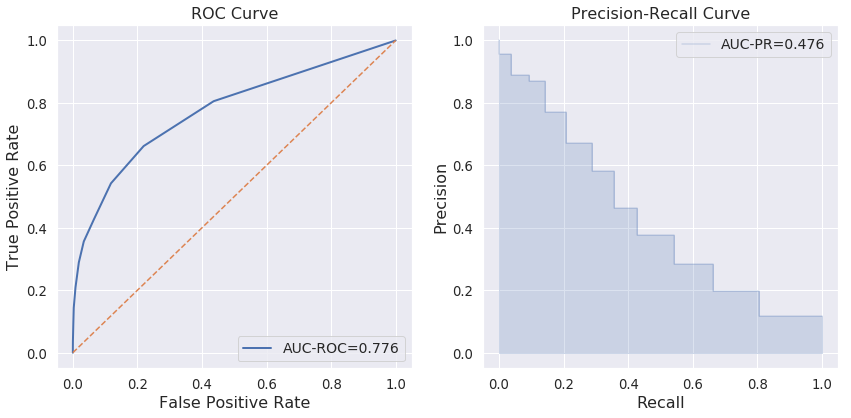

In [21]:
rf = RandomForestClassifier(random_state=2)
mymodeling.clf_print_results(rf,X_train_std,y_train, X_test_std, y_test)

### 3.3.2) Feature importances

The most important features are note, salaire, age and exp as shown in section 1).
Speciality and diplome variables are not important for the Random Forest algorithm but this is due to the encoding and splitting into binary features.

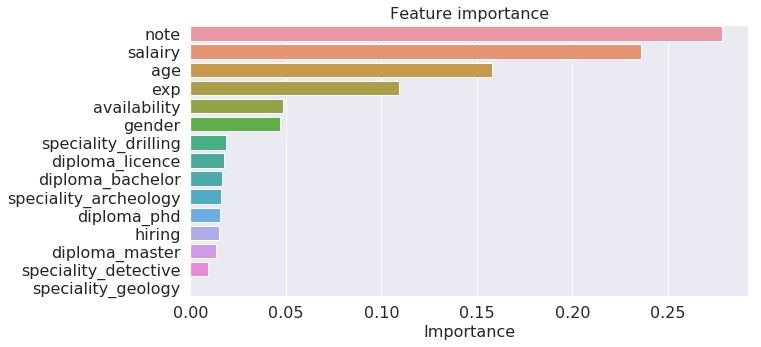

In [22]:
importanceTable = pd.DataFrame(rf.feature_importances_)
featureNameList = pd.DataFrame(data.columns)
importanceTable.columns = ['Importance']
featureNameList.columns = ['Features']
featureImportance = featureNameList.join(importanceTable)
featureImportance = featureImportance.sort_values(['Importance'],ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x=featureImportance['Importance'],
            y=featureImportance['Features'])
plt.xlabel('Importance',fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel("")
plt.yticks(fontsize=16)
plt.title("Feature importance", fontsize=16)
plt.show()

## 3.4) Model improvement

We propose some improvement clues for the baseline model and evaluate the results.
* grid search
* fill Nan values
* Principal Component Analysis

## 3.4.1) Grid search 

We perform a Grid search with cross validation on 3 stratified and randomized folds.<br>
In order to calibrate the parameters, a Random Search CV has been applied before. <br>

The Grid search stragety together with the cross validation allow to gain around 6%-9% of improvement.

Training... (scoring: {'F1': 'f1', 'AUC-PR': 'average_precision'} )

Best Parameters:  RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=80, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False, random_state=112,
            verbose=0, warm_start=False)
Best Score: 50.02%
Classification report:
              precision    recall  f1-score   support

          0       0.94      0.92      0.93      4632
          1       0.48      0.54      0.51       612

avg / total       0.88      0.88      0.88      5244

Accuracy 87.85%
---- Confusion matrix ----
[[4277  355]
 [ 282  330]]


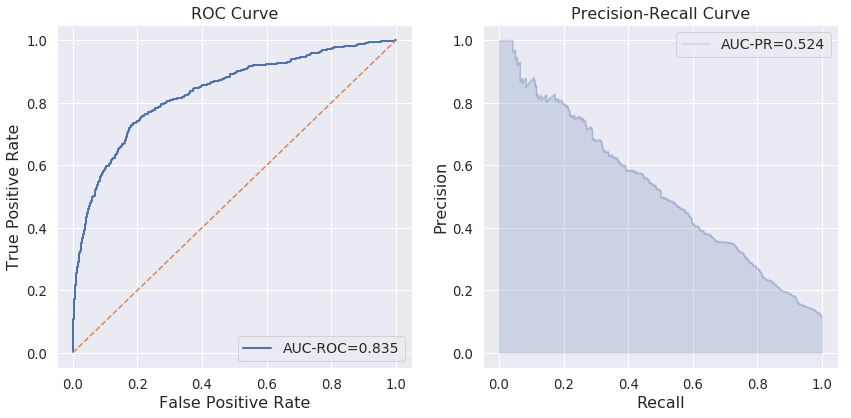

In [23]:
rf_gs = mymodeling.clf_gs(rf, X_train_std, y_train, X_test_std, y_test)
mymodeling.clf_print_results(rf_gs, X_train_std, y_train, X_test_std, y_test)

## 3.4.2) Data processing (fillna)

In order to improve the model, the NaN values are filled instead of removed.
We compare the result with the baseline by performing several predictions varying the random state parameter of the Random Forest algorithm and make an arithmetical mean.

We compare the AUC-ROC and AUC-PR, and we obtain about 0.85% of improvement for the AUC-ROC whereas it yields to about 0.15% of devaluation for the AUC-PR, which is not very probing.


### a) Fill NaN values

We perform a polynomial interpolation of order 3 for the numerical variables and a backward/forward fill-in for categorical variables.

In [24]:
data_fill = dataset.copy()
data_fill = data_fill.interpolate(method='polynomial', order=3, axis=0) # interpolate numerical values
data_fill = data_fill.ffill().bfill()  # fill NaN values of categorical variable
data_fill = mydata_processing.data_cleaning(data_fill)
data = data_fill.copy()
print("dasaset size:", data.shape)

dasaset size: (18195, 9)


In [25]:
data = mydata_processing.data_encoding(data)
X_train_fill, X_test_fill, y_train_fill, y_test_fill = mydata_processing.data_splitting(data)
X_train_std_fill, X_test_std_fill = mydata_processing.data_scaling(X_train_fill, X_test_fill)

### b) Performances comparison

In [26]:
rand_size = 400 
rf_result_rand_auc = []
rf_result_rand_pr = []
rf_result_rand_fill_auc = []
rf_result_rand_fill_pr = []
start_baseline = time.time()
for i in range(rand_size): 
    rf_rand = RandomForestClassifier(random_state = i)
    rf_auc, rf_pr = mymodeling.clf_roc_pr(rf_rand,X_train_std,y_train, X_test_std, y_test)
    rf_result_rand_auc.append(rf_auc)
    rf_result_rand_pr.append(rf_pr)
stop_baseline = time.time()    
print("Baseline CPU: %0.4f" % (stop_baseline-start_baseline))
    
start_fill = time.time()    
for i in range(rand_size):    
    rf_rand = RandomForestClassifier(random_state = i)
    rf_auc_fill_auc, rf_auc_fill_pr = mymodeling.clf_roc_pr(rf_rand,X_train_std_fill,y_train_fill, X_test_std_fill, y_test_fill)
    rf_result_rand_fill_auc.append(rf_auc_fill_auc)
    rf_result_rand_fill_pr.append(rf_auc_fill_pr)
stop_fill = time.time()    
print("Fillna CPU  : %0.4f" % (stop_fill-start_fill))

Baseline CPU: 58.7894
Fillna CPU  : 62.9864


In [27]:
mean_auc_baseline = mean(rf_result_rand_auc)
mean_auc_fill = mean(rf_result_rand_fill_auc)
mean_pr_baseline = mean(rf_result_rand_pr)
mean_pr_fill = mean(rf_result_rand_fill_pr)

print("----------- Arithmetical mean ------------\n")
print("Baseline AUC-ROC = %0.4f" % mean_auc_baseline)
print("Fillna   AUC-ROC = %0.4f" % mean_auc_fill)
print("=> %0.2f%% " % (100*(mean_auc_fill-mean_auc_baseline)/mean_auc_baseline))

print("\nBaseline AUC-PR = %0.4f" % mean_pr_baseline)
print("Fillna   AUC-PR = %0.4f" % mean_pr_fill)
print("=> %0.2f%%" % (100*(mean_pr_fill-mean_pr_baseline)/mean_pr_baseline))

----------- Arithmetical mean ------------

Baseline AUC-ROC = 0.7693
Fillna   AUC-ROC = 0.7766
=> 0.94% 

Baseline AUC-PR = 0.4580
Fillna   AUC-PR = 0.4570
=> -0.22%


## 3.4.3) Principal Component Analysis (PCA)

We perform a Principal component analysis in order to select the most important features that capture maximum information about the dataset.
We plot the variance of each principal component induced on the response variable. 
We observe that all the principal component are important, and cumulated variance is about 50% of total information.
This result means that we cannot remove component.
Nevertheless, the strategy might be less time consumming and demanding in resources since the number of features decreases.
Thus, the actual interest of PCA is reducing the computing cost but in our case unfortunaletly it does not.

We proceed to comparison as in subsection 3.4.2) and we obtain poor results: about 0.3% of improvement for the AUC-RC and 2% of reduction for the AUC-PR.


-------------------------------------------------------------------------------
      Explained variances:  [0.17122246 0.13089727 0.10678991 0.09615234]
      Total explained variance: 50.51%
-------------------------------------------------------------------------------




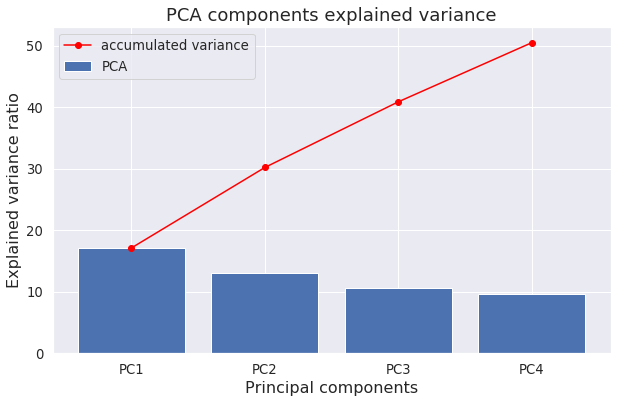

In [28]:
n_comp = 4
pca = PCA(n_components = n_comp)
pca = pca.fit(X_train_std)
X_train_pca = pca.fit_transform(X_train_std)  
X_test_pca = pca.transform(X_test_std) 

print("\n-------------------------------------------------------------------------------")
explained_variance = pca.explained_variance_ratio_  
print("      Explained variances: ", explained_variance)
print("      Total explained variance: %0.2f%%" % (100*explained_variance.sum()))
print("-------------------------------------------------------------------------------\n\n")

plt.figure(figsize=(10,6))
scree = pca.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree, label="PCA")
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o', label="accumulated variance")
plt.xlabel("Principal components", fontsize=16)
plt.xticks(np.arange(1,5),('PC1','PC2','PC3','PC4'))
plt.ylabel("Explained variance ratio", fontsize=16)
plt.title("PCA components explained variance", fontsize=18)
plt.legend(loc="upper left")
plt.show(block=False)

### b) Performances comparison

In [29]:
rf_result_rand_pca_auc = []
rf_result_rand_pca_pr = []
start_pca = time.time()
for i in range(rand_size):
    clf_rand_pca = RandomForestClassifier(random_state = i)
    rf_auc_pca, rf_pr_pca = mymodeling.clf_roc_pr(clf_rand_pca,X_train_pca,y_train, X_test_pca, y_test)
    rf_result_rand_pca_auc.append(rf_auc_pca)
    rf_result_rand_pca_pr.append(rf_pr_pca)
stop_pca = time.time()
print("PCA CPU: %0.4f" % (stop_pca-start_pca))

PCA CPU: 110.1464


In [30]:
print("----------- Arithmetical mean ------------\n")
mean_auc_pca = mean(rf_result_rand_pca_auc)
mean_pr_pca = mean(rf_result_rand_pca_pr)
print("Baseline AUC-ROC = %0.4f" % mean_auc_baseline)
print("Fillna   AUC-ROC = %0.4f" % mean_auc_pca)
print("=> %0.2f%% " % (100*(mean_auc_pca-mean_auc_baseline)/mean_auc_baseline))

print("\nBaseline AUC-PR = %0.4f" % mean_pr_baseline)
print("Fillna  AUC-PR = %0.4f" % mean_pr_pca)
print("=> %0.2f%%" % (100*(mean_pr_pca-mean_pr_baseline)/mean_pr_baseline))

----------- Arithmetical mean ------------

Baseline AUC-ROC = 0.7693
Fillna   AUC-ROC = 0.7720
=> 0.34% 

Baseline AUC-PR = 0.4580
Fillna  AUC-PR = 0.4479
=> -2.20%


# 4) Conclusion

The grid search strategy provides the best results with about 10% of improvement but it is time consuming.<br>
The fillna is not very satisfying but it might be improved by coupling it with a grid search.<br>
The PCA is not satisfying at all since there is only 0.3% of improvement for the AUC-ROC but a great reduction of AUC-PR and a higher CPU time.